<a href="https://colab.research.google.com/github/MonicaOsei/machine-learning-zoomcamp-homework/blob/main/Homework8_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
!unzip data.zip

--2025-12-01 15:20:29--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-01T15%3A54%3A32Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-01T14%3A54%3A06Z&ske=2025-12-01T15%3A54%3A32Z&sks=b&skv=2018-11-09&sig=JaUH3uYwL%2BOwMGtif5zZnO50FX1CIlhwss92b3z%2BdHk%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDYwNDIyOSwibmJmIjoxNzY0NjAyNDI5LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi

In [2]:
import torch

In [3]:
from PIL import Image
import numpy as np

In [4]:
import numpy as np
import torch

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

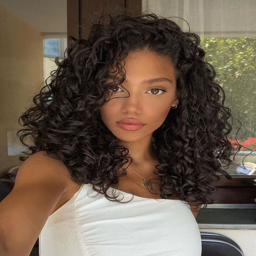

In [6]:
img = Image.open('/content/data/train/curly/00cbad1ffe22d900018e5a2e7376daed4.jpg')
img.resize((256, 256))

In [7]:
X = np.array(img.resize((200, 200)))

In [8]:
from torchvision import transforms

In [10]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(200),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [21]:
x = preprocess(img)

In [22]:
x.shape

torch.Size([3, 200, 200])

In [26]:
import torch.nn as nn

class HairCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 99 * 99, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [27]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

In [28]:
!pip install torchsummary

In [30]:
from torchsummary import summary

summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
              ReLU-2         [-1, 32, 200, 200]               0
         MaxPool2d-3         [-1, 32, 100, 100]               0
            Linear-4                   [-1, 64]      20,480,064
              ReLU-5                   [-1, 64]               0
            Linear-6                    [-1, 1]              65
Total params: 20,481,025
Trainable params: 20,481,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 21.97
Params size (MB): 78.13
Estimated Total Size (MB): 100.56
----------------------------------------------------------------


In [32]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),   # Resize images to 200x200
    transforms.ToTensor(),           # Convert PIL image to Tensor
    transforms.Normalize(            # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transforms = train_transforms

In [34]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

# Full training dataset
full_train_dataset = ImageFolder(root='/content/data/train', transform=train_transforms)

# Split into 80% train, 20% validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, val_size])

# Test dataset
test_dataset = ImageFolder(root='/content/data/test', transform=test_transforms)


In [35]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)


In [37]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6550, Acc: 0.6250, Val Loss: 0.5848, Val Acc: 0.6625
Epoch 2/10, Loss: 0.5356, Acc: 0.7156, Val Loss: 0.6000, Val Acc: 0.6562
Epoch 3/10, Loss: 0.4997, Acc: 0.7516, Val Loss: 0.5489, Val Acc: 0.7000
Epoch 4/10, Loss: 0.4620, Acc: 0.7812, Val Loss: 0.5362, Val Acc: 0.7375
Epoch 5/10, Loss: 0.4055, Acc: 0.8125, Val Loss: 0.5480, Val Acc: 0.7750
Epoch 6/10, Loss: 0.3029, Acc: 0.8672, Val Loss: 0.5894, Val Acc: 0.7438
Epoch 7/10, Loss: 0.2526, Acc: 0.8969, Val Loss: 0.7162, Val Acc: 0.7625
Epoch 8/10, Loss: 0.3106, Acc: 0.8688, Val Loss: 0.5422, Val Acc: 0.7375
Epoch 9/10, Loss: 0.1787, Acc: 0.9406, Val Loss: 0.8671, Val Acc: 0.7125
Epoch 10/10, Loss: 0.2347, Acc: 0.9047, Val Loss: 0.6466, Val Acc: 0.7625


In [38]:
median_acc = np.median(history['acc'])
std_loss = np.std(history['loss'])

print(f"Median training accuracy: {median_acc:.2f}")
print(f"Standard deviation of training loss: {std_loss:.3f}")


Median training accuracy: 0.84
Standard deviation of training loss: 0.145


In [40]:
from torchvision import transforms

train_augmented_transforms = transforms.Compose([
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = test_transforms


In [41]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Reload full train dataset with augmentations
full_train_dataset = ImageFolder(root='/content/data/train', transform=train_augmented_transforms)

# Split into train and validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, val_size])

# Update DataLoaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False)


In [43]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6537, Acc: 0.6594, Val Loss: 0.6204, Val Acc: 0.6188
Epoch 2/10, Loss: 0.6135, Acc: 0.6281, Val Loss: 0.5411, Val Acc: 0.6312
Epoch 3/10, Loss: 0.5738, Acc: 0.6609, Val Loss: 0.5025, Val Acc: 0.7312
Epoch 4/10, Loss: 0.5795, Acc: 0.7094, Val Loss: 0.4890, Val Acc: 0.7188
Epoch 5/10, Loss: 0.5645, Acc: 0.6906, Val Loss: 0.5118, Val Acc: 0.7000
Epoch 6/10, Loss: 0.5478, Acc: 0.6969, Val Loss: 0.4858, Val Acc: 0.7375
Epoch 7/10, Loss: 0.5435, Acc: 0.7312, Val Loss: 0.4729, Val Acc: 0.7312
Epoch 8/10, Loss: 0.5245, Acc: 0.7203, Val Loss: 0.4627, Val Acc: 0.7750
Epoch 9/10, Loss: 0.5169, Acc: 0.7422, Val Loss: 0.4412, Val Acc: 0.8063
Epoch 10/10, Loss: 0.4804, Acc: 0.7562, Val Loss: 0.4636, Val Acc: 0.7500


In [53]:
test_loss_epoch = 0.0
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss_epoch += loss.item() * images.size(0)  # sum weighted by batch size
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

mean_test_loss = test_loss_epoch / total
test_accuracy = correct / total

print(f"Mean test loss: {mean_test_loss:.3f}")
print(f"Test accuracy: {test_accuracy:.2f}")


Mean test loss: 0.543
Test accuracy: 0.75
